# Win prediction for League of Legends games
# E-sports Predictions
In this notebook we make a prediction model to predict the winners of professional matches of League of Legends. We begin with an introductory analysis comparing different classification models using the default hyperparameters. We then perform hyperparameter optimisation on each of these models, and finally compare the optimised models.

In [15]:
# Imports

import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import pickle 
import numpy as np
import matplotlib.pyplot as plt
import pickle

import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, precision_score


pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 40)

In [2]:
# Load the npy file produced in the preprocessing notebook
with open('../Preprocessing/ProPlay/processed_games.pkl', 'rb') as f:
    game_data = pickle.load(f)

In [3]:
game_data

,DATE,PATCH,BLUE_TEAM,RED_TEAM,GAME_WINNER,MATCH_WINNER,GAME_LENGTH,Kills_pm_BLUE,Kills_pm_RED,Assists_pm_BLUE,Assists_pm_RED,CS_pm_BLUE,CS_pm_RED,Golds_pm_BLUE,Golds_pm_RED,Total damage to Champion_pm_BLUE,Total damage to Champion_pm_RED,Physical Damage_pm_BLUE,Physical Damage_pm_RED,Magic Damage_pm_BLUE,Magic Damage_pm_RED,True Damage_pm_BLUE,True Damage_pm_RED,BLUEWIN,BLUE_TEAM_CODES,RED_TEAM_CODES,Kills_pm_BLUE_rolling,Assists_pm_BLUE_rolling,CS_pm_BLUE_rolling,Golds_pm_BLUE_rolling,Total damage to Champion_pm_BLUE_rolling,Physical Damage_pm_BLUE_rolling,Magic Damage_pm_BLUE_rolling,True Damage_pm_BLUE_rolling,Kills_pm_BLUErolling,Assists_pm_BLUErolling,CS_pm_BLUErolling,Golds_pm_BLUErolling,Total damage to Champion_pm_BLUErolling,Physical Damage_pm_BLUErolling,Magic Damage_pm_BLUErolling,True Damage_pm_BLUErolling
GAME_NUMBER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
44382,2022-10-16,12.18,Gen.G eSports,100 Thieves,Gen.G eSports,Gen.G eSports,1511,0.516214,0.079418,1.072138,0.119126,37.127730,28.908008,2176.002647,1430.152217,2332.137657,1433.527465,1027.147584,588.722700,1218.980807,786.909332,86.009265,57.895433,1,53,49,0.542467,1.332518,33.735502,1872.300316,2317.831937,1109.633954,970.230032,237.967951,-0.611120,-1.506159,-35.044113,-2020.633810,-1778.133825,-1019.842429,-651.102343,-107.189053
44381,2022-10-16,12.18,Royal Never Give Up,100 Thieves,Royal Never Give Up,Royal Never Give Up,2360,0.406780,0.254237,1.220339,0.711864,35.135593,33.355932,1844.288136,1784.084746,2402.033898,2094.737288,1150.042373,1195.754237,939.025424,854.364407,312.966102,44.618644,1,33,49,0.442832,0.983430,32.445098,1811.164429,2249.003364,1265.113549,775.957811,207.932004,-0.538494,-1.194696,-36.979566,-2064.875040,-2012.951869,-1061.849754,-828.522264,-122.579852
2235,2015-10-16,5.18,SKTelecom T1,AHQ E,SKTelecom T1,SKTelecom T1,2054,0.321324,0.146056,0.759494,0.379747,31.197663,28.422590,1761.207400,1426.971762,2067.517040,1266.777020,962.366115,740.944499,929.620253,416.932814,175.530672,108.899708,1,17,21,0.540966,1.147357,30.780580,1887.860530,1879.706770,951.165961,803.648886,124.891924,-0.407672,-0.934974,-28.324773,-1691.987814,-1693.039882,-812.493867,-811.469123,-69.076893
2237,2015-10-16,5.18,SKTelecom T1,AHQ E,SKTelecom T1,SKTelecom T1,2610,0.413793,0.275862,0.919540,0.367816,30.160920,30.367816,1665.402299,1535.678161,2446.114943,1748.551724,1067.908046,1189.080460,1129.264368,479.678161,248.942529,79.793103,1,17,21,0.530553,1.144111,30.677665,1871.991629,1944.274416,966.997401,816.150508,161.126507,-0.389606,-0.784801,-29.252506,-1686.052775,-1829.889558,-834.868107,-882.455197,-112.566254
14515,2018-10-21,8.19,Cloud9,Afreeca Freecs,Cloud9,Cloud9,1785,0.470588,0.369748,1.210084,0.436975,34.621849,33.512605,1968.369748,1656.537815,1677.613445,1860.302521,990.218487,508.873950,530.890756,1329.680672,156.504202,21.747899,1,46,47,0.505147,1.168059,35.495847,1935.258734,2062.624787,944.456974,1003.569540,114.598272,-0.333870,-0.668513,-36.371752,-1880.597136,-1419.787747,-734.171764,-615.658876,-69.957107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44356,2022-10-10,12.18,Rogue,Top Esports,Rogue,Rogue,2017,0.535449,0.178483,1.457610,0.386713,31.294001,31.769955,1930.143778,1617.055032,2105.027268,1700.079326,916.420426,700.664353,1133.158156,953.009420,55.448686,46.405553,1,70,63,0.436329,1.091289,31.544679,1794.135310,2203.395528,986.230850,1125.446327,91.718351,-0.396464,-0.875809,-33.242371,-1775.835446,-2237.030385,-1225.960976,-880.931397,-130.138012
44374,2022-10-15,12.18,GAM Esports,Top Esports,GAM Esports,GAM Esports,2491,0.505821,0.409474,1.324769,0.915295,28.109193,30.228824,1751.778402,1853.111200,2933.279807,3320.232838,841.830590,1700.112405,1741.758330,1201.686070,349.690887,418.434364,1,61,63,0.199424,0.537699,33.382292,1637.232301,1456.702951,730.993522,616.130556,109.578873,-0.413255,-1.0

# Introductory analysis

Here we perform a simple analysis of the data using the default settings for various classification models. 

In [5]:

rf = RandomForestClassifier(random_state = 42)
clf = DecisionTreeClassifier(random_state=42)
knn = KNeighborsClassifier()

classifier_names = ['rf', 'clf', 'knn']
classifiers = [rf, clf, knn]

In [6]:
train = game_data[(game_data['DATE'] < '2022-01-01') & (game_data['DATE'] > '2019-01-01')  ]
test = game_data[game_data['DATE'] > '2022-01-01']

In [7]:
main_predictors = ['BLUE_TEAM_CODES',
 'RED_TEAM_CODES']

predictors_blue = ['Kills_pm_BLUE_rolling',
 'Assists_pm_BLUE_rolling',
 'CS_pm_BLUE_rolling',
 'Golds_pm_BLUE_rolling',
 'Total damage to Champion_pm_BLUE_rolling',
 'Physical Damage_pm_BLUE_rolling',
 'Magic Damage_pm_BLUE_rolling',
 'True Damage_pm_BLUE_rolling']

predictors_red = ['Kills_pm_BLUErolling',
 'Assists_pm_BLUErolling',
 'CS_pm_BLUErolling',
 'Golds_pm_BLUErolling',
 'Total damage to Champion_pm_BLUErolling',
 'Physical Damage_pm_BLUErolling',
 'Magic Damage_pm_BLUErolling',
 'True Damage_pm_BLUErolling']

predictors = main_predictors + predictors_blue + predictors_red

In [12]:
X_train =  train[predictors]
y_train = train['BLUEWIN']

X_test = test[predictors]
y_test = test['BLUEWIN']

In [13]:
metrics = {'metric':['acc', 'prec']}
for model, name in list(zip(classifiers, classifier_names)):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)
    metrics[name] = [acc, prec] 


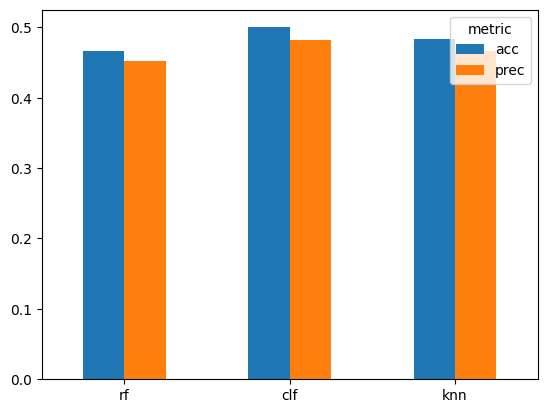

In [9]:
df = pd.DataFrame(metrics).set_index('metric').T
df.plot.bar(rot=0)
plt.show()

# Hyperparameter tuning: RF
Here we look at some hyperparameter tuning for various models. We begin with RF.

In [43]:
%%time
# List Hyperparameters that we want to tune.
max_depth = list(np.arange(10,110,40))
min_samples_leaf = [1, 4]
min_samples_split = [2, 5]
n_estimators = list(np.arange(100,1100,200))

# Convert to dictionary
hyperparameters = dict(bootstrap=bootstrap, max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, n_estimators=n_estimators)

# Create new KNN object
rf_2 = RandomForestClassifier()

# Use GridSearch
GSCV = GridSearchCV(rf_2, hyperparameters, cv=10)

# Fit the model
best_model = GSCV.fit(X_train,y_train)

# Print The value of best Hyperparameters
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best min_samples_leaf:', best_model.best_estimator_.get_params()['min_samples_leaf'])
print('Best min_samples_split:', best_model.best_estimator_.get_params()['min_samples_split'])
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])

Best max_depth: 90
Best min_samples_leaf: 1
Best min_samples_split: 2
Best n_estimators: 100
Wall time: 6min 12s


# Hyperparameter tuning: CLF
Here we look at some hyperparameter tuning for various models. We continue with CLF.

# Hyperparameter tuning: KNN
Here we look at some hyperparameter tuning for various models. We continue with KNN.

In [34]:
%%time
# List Hyperparameters that we want to tune.
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]

# Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

# Create new KNN object
knn_2 = KNeighborsClassifier()

# Use GridSearch
GSCV = GridSearchCV(knn_2, hyperparameters, cv=10)

# Fit the model
best_model = GSCV.fit(X_train,y_train)

# Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best leaf_size: 1
Best p: 2
Best n_neighbors: 15
Wall time: 1min 3s
